<a href="https://colab.research.google.com/github/b62mp1/files/blob/main/Graphs%26Metrics/RNN/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader
from pandas.plotting import lag_plot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import *
from keras import callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from pandas_datareader import data as pdr
yf.pdr_override()

In [28]:
stock_name = "TSLA"
df=pdr.get_data_yahoo(stock_name, start=('2020-01-01'), end='2022-04-19').reset_index()
print("Number of rows and columns:", df.shape)
df.head(5)

[*********************100%***********************]  1 of 1 completed
Number of rows and columns: (578, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,84.900002,86.139999,84.342003,86.052002,86.052002,47660500
1,2020-01-03,88.099998,90.800003,87.384003,88.601997,88.601997,88892500
2,2020-01-06,88.094002,90.311996,88.000000,90.307999,90.307999,50665000
3,2020-01-07,92.279999,94.325996,90.671997,93.811996,93.811996,89410500
4,2020-01-08,94.739998,99.697998,93.646004,98.428001,98.428001,155721500


In [29]:
# Check for missing values
def num_missing(x):
    return sum(x.isnull())

print("Missing values per column:")
print(df.apply(num_missing, axis=0))

print("\nMissing values per row:")
print(df.apply(num_missing, axis=1).head())

def window_dataset(series, window_size, batch_size=128,
                  shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Missing values per column:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Missing values per row:
0    0
1    0
2    0
3    0
4    0
dtype: int64


In [30]:
# Split the data into training and test datasets
split_index = int(len(df.values) * 0.80)
training_set = df.iloc[:split_index, 4:5].values
test_set = df.iloc[split_index:, 4:5].values
# Normalizing and reshaping the training data

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, split_index):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape


(402, 60, 1)

In [31]:
# Normalizing and reshaping the testing data
dataset_train = df.iloc[:split_index, 4:5]
dataset_test = df.iloc[split_index:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
Y_test = []
for i in range(60, len(dataset_total) - split_index + 60):
    X_test.append(inputs[i-60:i, 0])
    Y_test.append(inputs[i])
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(116, 60, 1)

In [32]:
# Building RNN model

# Clear any back end stored data due to multiple iterations
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size
window_size = 30

# Create 2D batches of batch size and features (1 feature = 1 time step in window)
train_set = window_dataset(training_set_scaled, window_size, batch_size=128)

# Establish Model
model_rnn = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # Add a 3rd dimension (feature dimensionality which in this case in univariate)
                      input_shape=[None]), # 1st dimension is batch size, input shape = None allows windows of any size to be used
  keras.layers.SimpleRNN(100, return_sequences=True), # takes in sequence (batch size, time, dimensionality per time step (univariate))
  keras.layers.SimpleRNN(100), # produces a single vector
  keras.layers.Dense(1), # produces 1 output 
])

# Early stopping to prevent overfitting
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=50, restore_best_weights=True)

# Put model all together
model_rnn.compile(loss='mean_squared_error',optimizer='adam')
model_rnn.fit(train_set, epochs=100, batch_size=32)


Epoch 1/100
4/4 [==============================] - 2s 41ms/step - loss: 0.2961
Epoch 2/100
4/4 [==============================] - 0s 34ms/step - loss: 0.0768
Epoch 3/100
4/4 [==============================] - 0s 40ms/step - loss: 0.0366
Epoch 4/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0130
Epoch 5/100
4/4 [==============================] - 0s 36ms/step - loss: 0.0124
Epoch 6/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0069
Epoch 7/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0041
Epoch 8/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0042
Epoch 9/100
4/4 [==============================] - 0s 56ms/step - loss: 0.0032
Epoch 10/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0027
Epoch 11/100
4/4 [==============================] - 0s 36ms/step - loss: 0.0022
Epoch 12/100
4/4 [==============================] - 0s 38ms/step - loss: 0.0019
Epoch 13/100
4/4 [==============================]

In [33]:
# Predicting the values
# All values normalized to training data
spy_normalized_to_traindata = sc.transform(dataset_total.values.reshape(-1, 1))
rnn_forecast = model_forecast(
    model_rnn,
    spy_normalized_to_traindata[split_index - window_size:-1],
    window_size)[:, 0]
rnn_predicted_stock_price = sc.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()


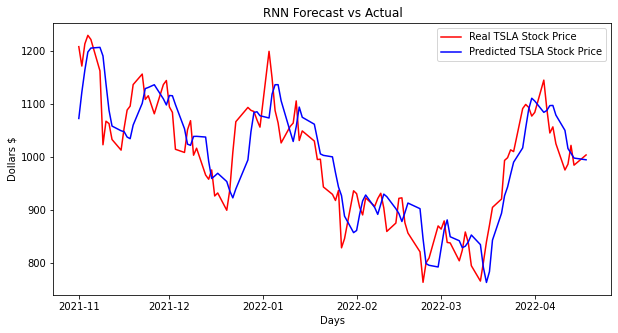

In [34]:
# Visualising the results
plt.figure(figsize=(10, 5))
plt.plot(df.loc[split_index:, 'Date'],dataset_test.values, color = 'red', label = 'Real ' + stock_name + ' Stock Price')
plt.plot(df.loc[split_index:, 'Date'],rnn_predicted_stock_price, color = 'blue', label = 'Predicted ' + stock_name + ' Stock Price')
plt.ylabel('Dollars $')
plt.xlabel('Days')
plt.title('RNN Forecast vs Actual')
plt.legend(loc="upper right")
plt.show()